<a href="https://colab.research.google.com/github/mahmud-nobe/Cluster-Membership/blob/master/Binary_Cluster_884_869/Cluster_membership_RF_Classifier_NGC884_and_NGC_869_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Necessary Packages

In [1]:
# import packages
import pandas as pd
import pandas_profiling as pd_prof
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Use random forest to create and evaluate new model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from astropy import coordinates as coord
from astropy import units as u


In [3]:
c = coord.SkyCoord.from_name('NGC869')
print(c)
# type(c.ra.degree), (c.ra.degree)
# help(c.ra)

<SkyCoord (ICRS): (ra, dec) in deg
    (34.75, 57.12833333)>


### Import and Examining the Training Data

Separating the predictors (features) and the output (target, here PMemb) from the dataset and train the random forest model.

In [4]:
# import binary_cluster dataset
member = pd.read_csv('https://raw.githubusercontent.com/mahmud-nobe/Cluster-Membership/master/Binary_Cluster_884_869/binary_cluster_cantat.csv')
member.head(5)

PMemb  Cluster     source_id  ...    Ecl_Lat      ruwe       mag
0    0.4  NGC_869  4.583740e+17  ...  40.308499  0.935096  17.50616
1    0.4  NGC_869  4.583780e+17  ...  40.363816  1.003925  11.03149
2    0.2  NGC_869  4.583690e+17  ...  40.314197  1.076254  15.56785
3    0.6  NGC_869  4.583630e+17  ...  40.259285  1.099435  16.59599
4    0.3  NGC_869  4.583680e+17  ...  40.276601  1.029976  15.88840

[5 rows x 61 columns]

In [5]:
# Examining the descriptive statistics of each column
member.describe()

PMemb     source_id  ...         ruwe          mag
count  2529.000000  2.529000e+03  ...  2529.000000  2529.000000
mean      0.513523  4.584123e+17  ...     1.003738    15.180414
std       0.246444  5.824269e+13  ...     0.161572     1.825734
min       0.100000  4.583060e+17  ...     0.757964     6.210630
25%       0.300000  4.583740e+17  ...     0.947031    14.246650
50%       0.500000  4.583980e+17  ...     0.992049    15.522440
75%       0.700000  4.584360e+17  ...     1.037851    16.463670
max       1.000000  4.586640e+17  ...     5.582955    17.998780

[8 rows x 60 columns]

In [0]:
### adding their distance from the center of both clusters

## NGC 869
center = coord.SkyCoord.from_name('NGC869')
center_ra, center_dec = center.ra.degree, center.dec.degree
distance = np.sqrt( (member['ra'] - center_ra)**2 + (member['dec'] - center_dec)**2 )
member['dist_869_center'] = distance

## NGC 884
center = coord.SkyCoord.from_name('NGC884')
center_ra, center_dec = center.ra.degree, center.dec.degree
distance = np.sqrt( (member['ra'] - center_ra)**2 + (member['dec'] - center_dec)**2 )
member['dist_884_center'] = distance


In [7]:
field_star = member['PMemb'] < 0.5
member['Cluster'][field_star] = 'Field'
member['Cluster'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Field      988
NGC_869    920
NGC_884    621
Name: Cluster, dtype: int64

In [0]:
# Profile report of the full dataset
# pd_prof.ProfileReport(member)

In [53]:
# Probable members (PMemb >= 0.5) in this dataset
len(member[member['Cluster'] != 'Field'])

1541

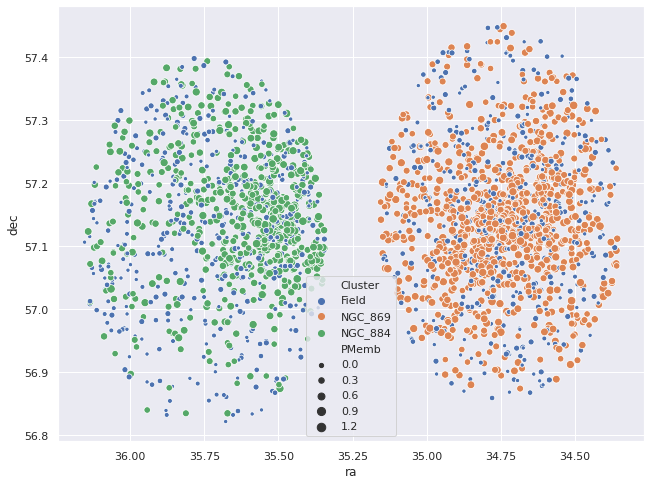

In [54]:
sns.set(rc={'figure.figsize':(10.5,8)})

skyplot = sns.scatterplot(member['ra'], member['dec'], hue=member['Cluster'], size = member['PMemb'])
skyplot.invert_xaxis()

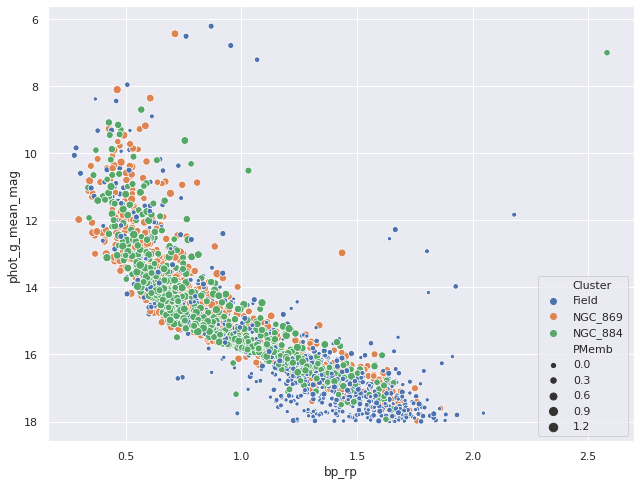

In [55]:
# CMD marked with the membership probabilities of the stars 
# (PMemb >= 0.5 stars are the probable stars)

cmd = sns.scatterplot(member['bp_rp'], member['phot_g_mean_mag'], hue=member['Cluster'], size = member['PMemb'])
cmd.invert_yaxis()

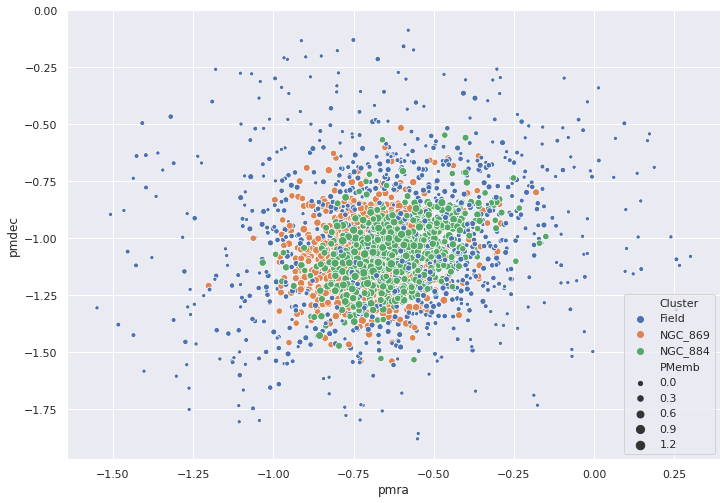

In [56]:
# proper motion plot marked with the membership probabilities of the stars 

sns.set(rc={'figure.figsize':(11.7,8.27)})
pm_plot = sns.scatterplot(member['pmra'], member['pmdec'], hue=member['Cluster'], size = member['PMemb'])

In [75]:
# data type of each variable
member.dtypes

PMemb              float64
Cluster             object
source_id          float64
ra                 float64
ra_error           float64
                    ...   
Ecl_Lat            float64
ruwe               float64
mag                float64
dist_869_center    float64
dist_884_center    float64
Length: 63, dtype: object

In [8]:
# correlation of PMemb with other variables
member.corr().PMemb.sort_values()

ra_error                          -0.488393
astrometric_pseudo_colour_error   -0.486473
pmra_error                        -0.479879
parallax_error                    -0.479258
dec_error                         -0.474843
                                     ...   
phot_bp_mean_flux_over_error       0.376905
phot_g_mean_flux_over_error        0.408435
astrometric_pseudo_colour          0.421204
parallax_over_error                0.464685
PMemb                              1.000000
Name: PMemb, Length: 62, dtype: float64

In [89]:
# Choosing the predictors
features = member.loc[:,['ra',	'ra_error',	'dec', 'dec_error',	
                         'parallax', 'parallax_error',	'parallax_over_error', 
                         'pmra',	'pmra_error',	'pmdec',	'pmdec_error',
                         'phot_g_mean_mag', 'bp_rp', 'dist_869_center', 'dist_884_center']]
features

ra      pmra     pmdec  dist_869_center  dist_884_center
0     34.900785 -0.954020 -1.506319         0.151317         0.695111
1     34.744249 -0.342761 -0.756019         0.010061         0.851663
2     34.694726 -0.145917 -0.698945         0.081174         0.902853
3     35.115957 -0.502487 -1.183384         0.366152         0.479953
4     34.685825 -0.932498 -0.710651         0.121664         0.915490
...         ...       ...       ...              ...              ...
2524  35.475146 -0.068968 -1.517004         0.725409         0.121766
2525  35.820625 -0.490251 -0.933062         1.070625         0.224806
2526  35.504081 -1.096121 -0.913376         0.754218         0.092413
2527  35.875661 -0.395499 -0.937896         1.125684         0.279853
2528  35.547000 -0.563553 -0.920536         0.797227         0.051289

[2529 rows x 5 columns]

In [90]:
# Descriptive stats
features.describe()

ra         pmra        pmdec  dist_869_center  dist_884_center
count  2529.000000  2529.000000  2529.000000      2529.000000      2529.000000
mean     35.150624    -0.643961    -1.040802         0.508950         0.572751
std       0.495088     0.222603     0.230910         0.399284         0.358048
min      34.357227    -1.549781    -1.879070         0.003802         0.007013
25%      34.721340    -0.763235    -1.175979         0.162184         0.206158
50%      34.980025    -0.648053    -1.058378         0.320477         0.628859
75%      35.586616    -0.523913    -0.928115         0.845141         0.882566
max      36.154135     0.300520    -0.086586         1.404309         1.238802

In [124]:
features2 = member.iloc[:,3:]
features2 = features2.drop('mag', axis = 1)
features2

ra  ra_error  ...  dist_869_center  dist_884_center
0     34.900785  0.064429  ...         0.151317         0.695111
1     34.744249  0.028451  ...         0.010061         0.851663
2     34.694726  0.028647  ...         0.081174         0.902853
3     35.115957  0.040829  ...         0.366152         0.479953
4     34.685825  0.032343  ...         0.121664         0.915490
...         ...       ...  ...              ...              ...
2524  35.475146  0.095398  ...         0.725409         0.121766
2525  35.820625  0.022487  ...         1.070625         0.224806
2526  35.504081  0.045745  ...         0.754218         0.092413
2527  35.875661  0.027769  ...         1.125684         0.279853
2528  35.547000  0.016082  ...         0.797227         0.051289

[2529 rows x 59 columns]

In [125]:
# The outcome that we want to use to train our model
targets = member['Cluster']
targets

0         Field
1         Field
2         Field
3       NGC_869
4         Field
         ...   
2524      Field
2525    NGC_884
2526      Field
2527      Field
2528    NGC_884
Name: Cluster, Length: 2529, dtype: object

In [0]:
features = features2

In [127]:
# Dropping the NULL values from the using training set
# adding features and targets in a training set
training_set = pd.concat((features, targets), axis=1)

# dropping NA
training_set = training_set.dropna()

# set features, targets again
features, targets = training_set.iloc[:,:-1], training_set.iloc[:,-1]

features.describe()

ra     ra_error  ...  dist_869_center  dist_884_center
count  2508.000000  2508.000000  ...      2508.000000      2508.000000
mean     35.150426     0.033853  ...         0.509177         0.573281
std       0.495617     0.018471  ...         0.399492         0.358225
min      34.357227     0.012364  ...         0.003802         0.007013
25%      34.720499     0.021183  ...         0.162219         0.206372
50%      34.979644     0.027635  ...         0.320719         0.629738
75%      35.586815     0.040513  ...         0.845177         0.883560
max      36.154135     0.144425  ...         1.404309         1.238802

[8 rows x 59 columns]

In [128]:
type(targets)
targets.dtypes
targets.isna().sum()

0

In [129]:
# changing the data type to 32-bit-float number as the built-in radom forest package 
# don't take 64-bit-float
from numpy import float32
features = features.astype('float32')
# targets = targets.astype('float32')
features.dtypes

ra                                  float32
ra_error                            float32
dec                                 float32
dec_error                           float32
parallax                            float32
parallax_error                      float32
parallax_over_error                 float32
pmra                                float32
pmra_error                          float32
pmdec                               float32
pmdec_error                         float32
ra_dec_corr                         float32
ra_parallax_corr                    float32
ra_pmra_corr                        float32
ra_pmdec_corr                       float32
dec_parallax_corr                   float32
dec_pmra_corr                       float32
dec_pmdec_corr                      float32
parallax_pmra_corr                  float32
parallax_pmdec_corr                 float32
pmra_pmdec_corr                     float32
astrometric_n_obs_al                float32
astrometric_n_good_obs_al       

In [130]:
# Use Random Forest on whole dataset using 1000 different trees 
rfc = RandomForestClassifier(n_estimators = 1000, oob_score = True)
rfc.fit(features, targets)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [131]:
# checking the feature importance, 
# ( this is higher for a variable if the model efficiency become lower as we remove that variable)
feature_imp = pd.Series(rfc.feature_importances_, index=features.columns).sort_values(ascending = False)
feature_imp

l                                   0.067205
dist_869_center                     0.065412
ra                                  0.061194
pmdec                               0.060087
pmra                                0.057502
Ecl_Lon                             0.056529
dist_884_center                     0.042581
Ecl_Lat                             0.030746
parallax_over_error                 0.025673
parallax                            0.021495
b                                   0.021335
ra_error                            0.018914
pmra_error                          0.017265
astrometric_weight_al               0.015996
astrometric_pseudo_colour_error     0.015516
astrometric_sigma5d_max             0.015306
pmra_pmdec_corr                     0.014946
dec_error                           0.014805
pmdec_error                         0.014598
phot_rp_mean_flux                   0.012238
dec                                 0.011824
parallax_error                      0.011590
phot_rp_me

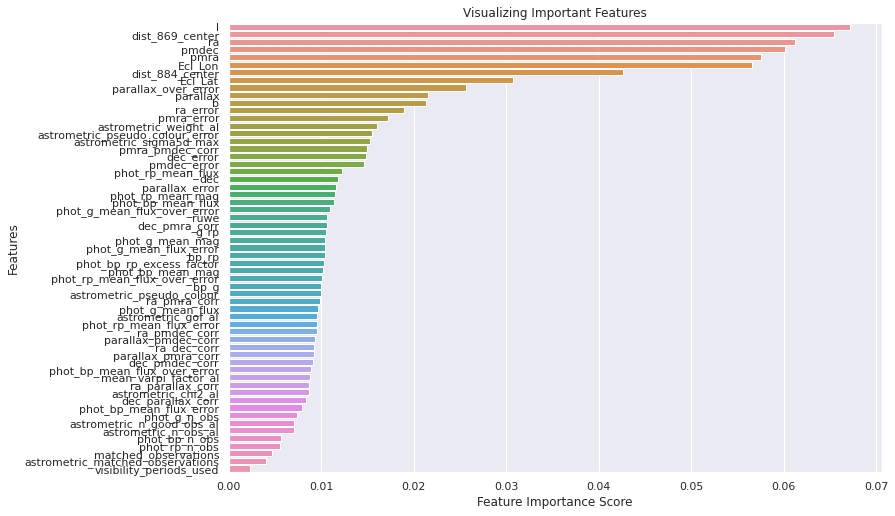

In [132]:
# plotting as a barplot

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Estimating the Model Accuracy in Test Data

In [0]:
# function for splitting a given dataset into training and test dataset

import random
# X = predictors, Y = target
def test_train_split(X, Y, test_ratio):
  ntest = int(len(X)*test_ratio) 
  ntrain = int(len(X) - ntest)

  # randomly select ntest number of rows from the full dataset as test_index and mark others as train_index.
  ind_test = random.sample(range(len(X)), k = ntest)
  ind_train = list(set(range(len(X))) - set(ind_test))

  # test and train dataset has the observations of test_indices and train_indices respectively
  test_X = X.iloc[ind_test]
  test_Y = Y.iloc[ind_test]

  train_X = X.iloc[ind_train]
  train_Y = Y.iloc[ind_train]

  return test_X, test_Y, train_X, train_Y

In [0]:
# splitting our dataset using 0.3 test ratio (30% test data, 70% train data)
test_features, test_targets, train_features, train_targets = test_train_split(features, targets, 0.3)


In [135]:
# train the model using only training subset
rfc.fit(train_features, train_targets)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [136]:
# find the accuracy rate to predict the outcome for test subset
test_predict = rfc.predict(test_features)
rfc.score(test_features, test_targets)

0.7632978723404256

[[0.62828947 0.21381579 0.15789474]
 [0.15438596 0.84561404 0.        ]
 [0.12883436 0.         0.87116564]]


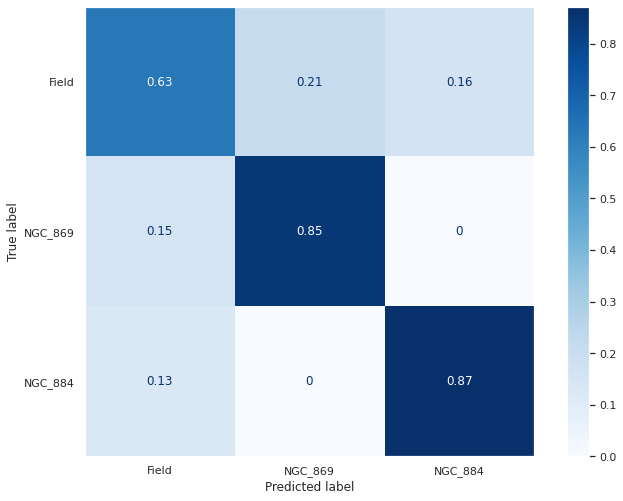

In [137]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(rfc, test_features, test_targets,
display_labels=rfc.classes_, cmap=plt.cm.Blues, normalize = 'true')
plt.grid(False)

print(disp.confusion_matrix)

In [138]:
# Check with different test ratio

test_ratio = np.linspace(0.95, 0.05, 19)
print(test_ratio)

[0.95 0.9  0.85 0.8  0.75 0.7  0.65 0.6  0.55 0.5  0.45 0.4  0.35 0.3
 0.25 0.2  0.15 0.1  0.05]


In [139]:

# for each test_ratio, estimate the accuracy of the model

accuracy_rate = []

for ratio in test_ratio:
  test_features, test_targets, train_features, train_targets = test_train_split(features, targets, ratio)

  # train the model using only training subset
  rfc.fit(train_features, train_targets)

  # find the accuracy rate to predict the outcome for test subset
  test_predict = rfc.predict(test_features)
  accuracy = rfc.score(test_features, test_targets)

  accuracy_rate.append(accuracy)

print(accuracy_rate)

[0.7195633921074727, 0.7226406734603456, 0.7334584702017832, 0.744765702891326, 0.7698032961190856, 0.7652421652421653, 0.7693251533742331, 0.7732712765957447, 0.7730239303843365, 0.7703349282296651, 0.7792553191489362, 0.7926221335992024, 0.7890535917901939, 0.7938829787234043, 0.8293460925039873, 0.812375249500998, 0.8191489361702128, 0.796, 0.808]


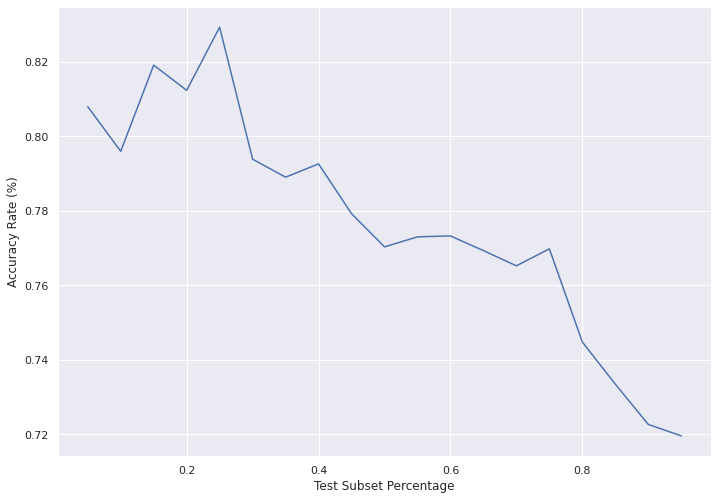

In [140]:
# plotting the accuracy rate vs test-ratio

sns.lineplot(test_ratio, accuracy_rate)
plt.xlabel('Test Subset Percentage')
plt.ylabel('Accuracy Rate (%)')
plt.show()

### Feature Engineering

In [0]:
all_features = features 

Test Features 1 : ['ra' 'ra_error' 'dec' 'dec_error' 'parallax' 'parallax_error'
 'parallax_over_error' 'pmra' 'pmra_error' 'pmdec' 'pmdec_error'
 'phot_g_mean_mag' 'bp_rp' 'dist_869_center' 'dist_884_center']


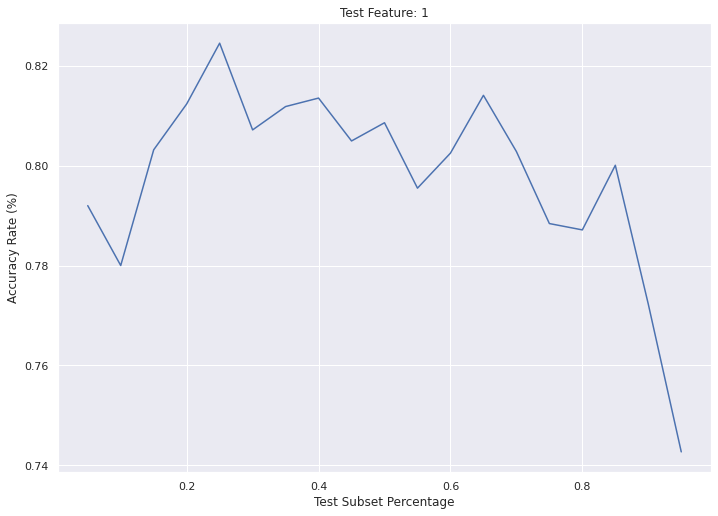

Test Features 2 : ['ra_error' 'dec' 'dec_error' 'parallax' 'parallax_error'
 'parallax_over_error' 'pmra' 'pmra_error' 'pmdec' 'pmdec_error'
 'phot_g_mean_mag' 'bp_rp']


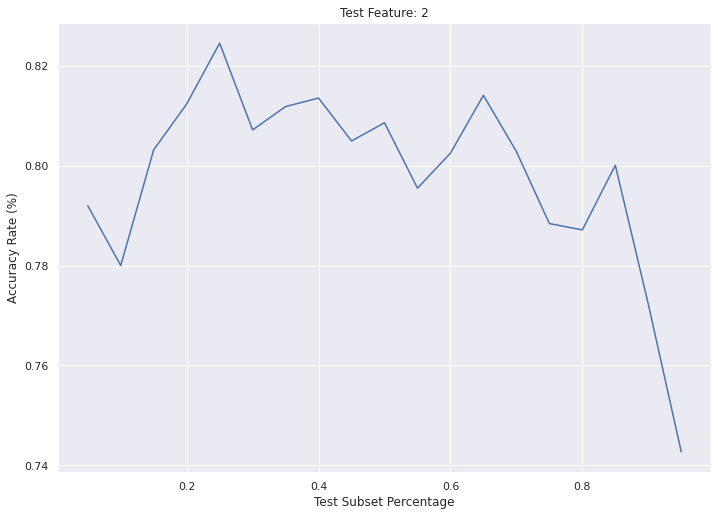

Test Features 3 : ['ra' 'ra_error' 'parallax' 'parallax_error' 'parallax_over_error' 'pmra'
 'pmra_error' 'pmdec' 'pmdec_error' 'dist_869_center' 'dist_884_center']


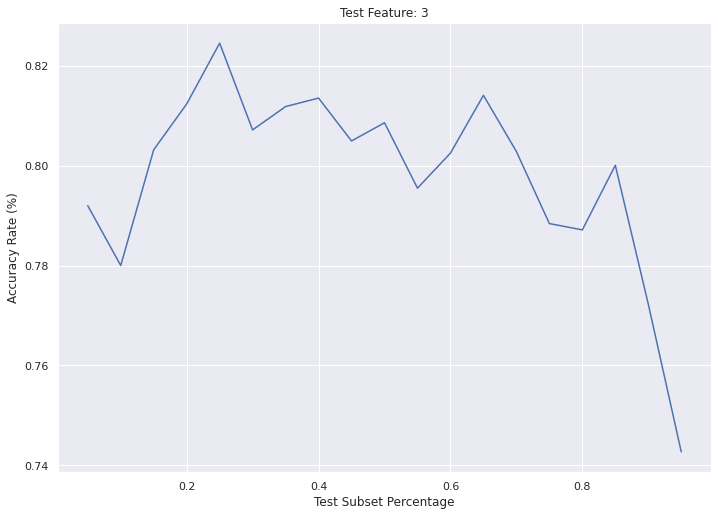

Test Features 4 : ['ra' 'ra_error' 'dec' 'dec_error' 'parallax' 'parallax_error'
 'parallax_over_error' 'pmra' 'pmra_error' 'pmdec' 'pmdec_error'
 'dist_869_center' 'dist_884_center']


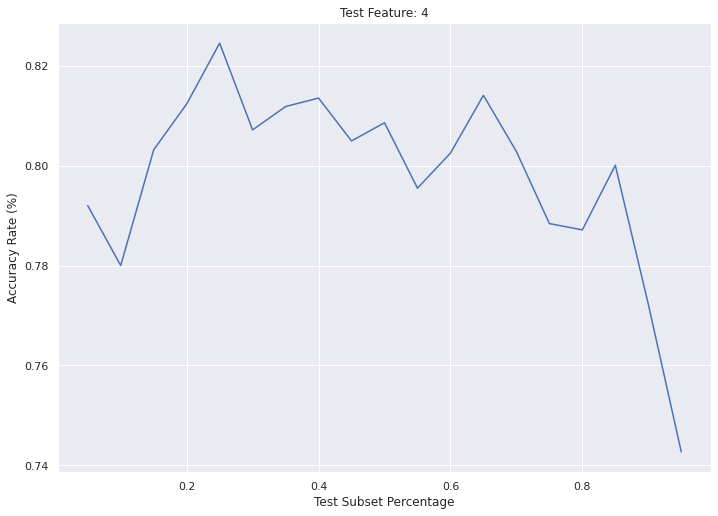

Test Features 5 : ['ra' 'ra_error' 'dec' 'dec_error' 'parallax' 'parallax_error'
 'parallax_over_error' 'pmra' 'pmra_error' 'pmdec' 'pmdec_error'
 'ra_dec_corr' 'ra_parallax_corr' 'ra_pmra_corr' 'ra_pmdec_corr'
 'dec_parallax_corr' 'dec_pmra_corr' 'dec_pmdec_corr' 'parallax_pmra_corr'
 'parallax_pmdec_corr' 'pmra_pmdec_corr' 'astrometric_n_obs_al'
 'astrometric_n_good_obs_al' 'astrometric_gof_al' 'astrometric_chi2_al'
 'astrometric_weight_al' 'astrometric_pseudo_colour'
 'astrometric_pseudo_colour_error' 'mean_varpi_factor_al'
 'astrometric_matched_observations' 'visibility_periods_used'
 'astrometric_sigma5d_max' 'matched_observations' 'phot_g_n_obs'
 'phot_g_mean_flux' 'phot_g_mean_flux_error' 'phot_g_mean_flux_over_error'
 'phot_g_mean_mag' 'phot_bp_n_obs' 'phot_bp_mean_flux'
 'phot_bp_mean_flux_error' 'phot_bp_mean_flux_over_error'
 'phot_bp_mean_mag' 'phot_rp_n_obs' 'phot_rp_mean_flux'
 'phot_rp_mean_flux_error' 'phot_rp_mean_flux_over_error'
 'phot_rp_mean_mag' 'phot_bp_rp_excess

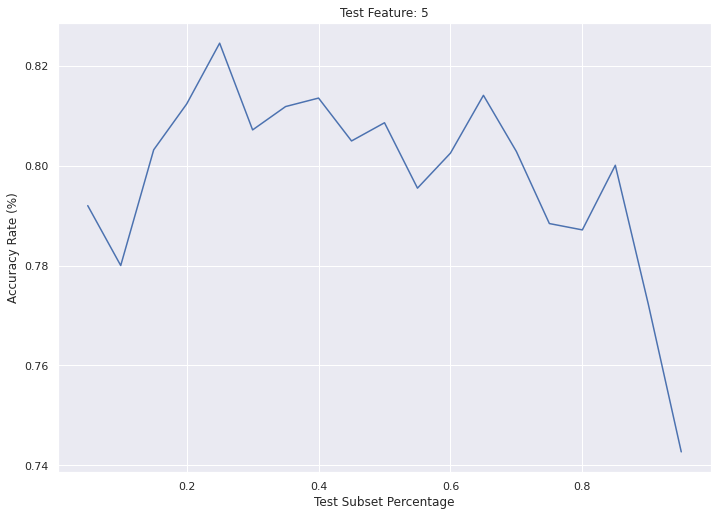

In [186]:
# Choosing the predictors
testing = [0,0,0,0,0]

testing[0] = all_features.loc[:,['ra',	'ra_error',	'dec', 'dec_error',	
                         'parallax', 'parallax_error',	'parallax_over_error', 
                         'pmra',	'pmra_error',	'pmdec',	'pmdec_error',
                         'phot_g_mean_mag', 'bp_rp', 'dist_869_center', 'dist_884_center']]

testing[1] = all_features.loc[:,['ra_error', 'dec', 'dec_error',	
                         'parallax', 'parallax_error',	'parallax_over_error', 
                         'pmra',	'pmra_error',	'pmdec',	'pmdec_error',
                         'phot_g_mean_mag', 'bp_rp']]

testing[2] = all_features.loc[:,['ra',	'ra_error',	
                         'parallax', 'parallax_error',	'parallax_over_error', 
                         'pmra',	'pmra_error',	'pmdec',	'pmdec_error',
                         'dist_869_center', 'dist_884_center']]

testing[3] = all_features.loc[:,['ra',	'ra_error',	'dec', 'dec_error',	
                         'parallax', 'parallax_error',	'parallax_over_error', 
                         'pmra',	'pmra_error',	'pmdec',	'pmdec_error',
                         'dist_869_center', 'dist_884_center']]

testing[4] = all_features

for i in range(5):
    features = test_features[i]
    print('Test Features',i+1,':', features.columns.values)

    sns.lineplot(test_ratio, accuracy_rate)
    plt.xlabel('Test Subset Percentage')
    plt.ylabel('Accuracy Rate (%)')
    plt.title('Test Feature: '+str(i+1))
    plt.show()

Test Features 1 : ['ra' 'ra_error' 'dec' 'dec_error' 'parallax' 'parallax_error'
 'parallax_over_error' 'pmra' 'pmra_error' 'pmdec' 'pmdec_error'
 'phot_g_mean_mag' 'bp_rp' 'dist_869_center' 'dist_884_center']


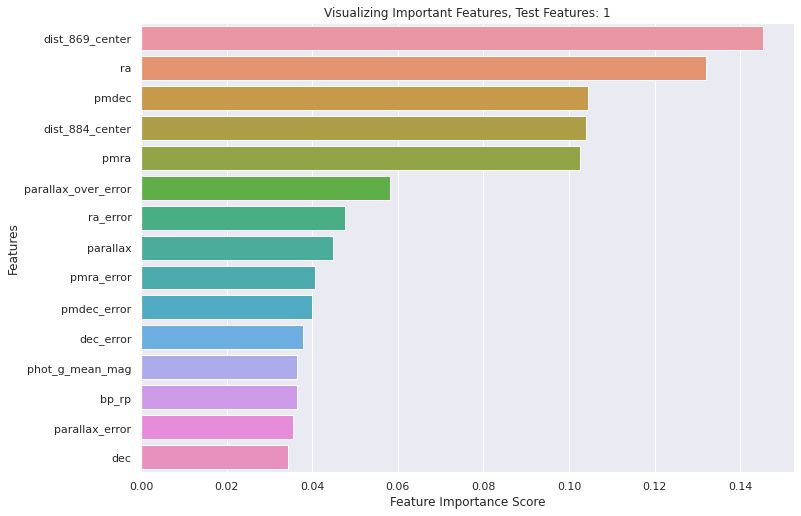

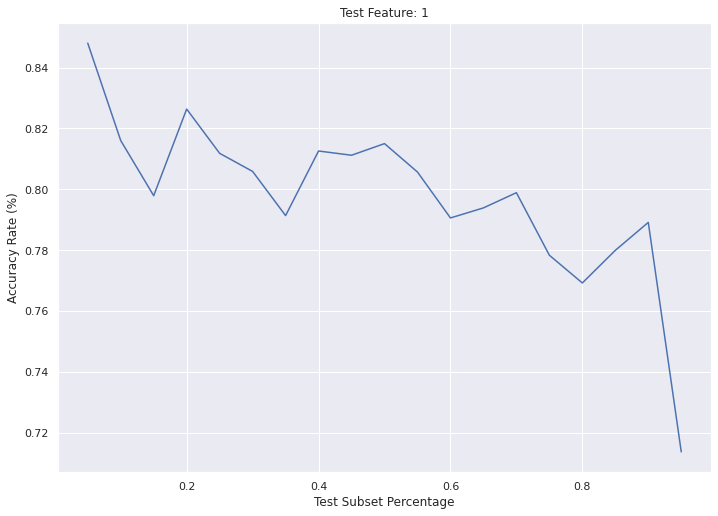

Test Features 2 : ['ra_error' 'dec' 'dec_error' 'parallax' 'parallax_error'
 'parallax_over_error' 'pmra' 'pmra_error' 'pmdec' 'pmdec_error'
 'phot_g_mean_mag' 'bp_rp']


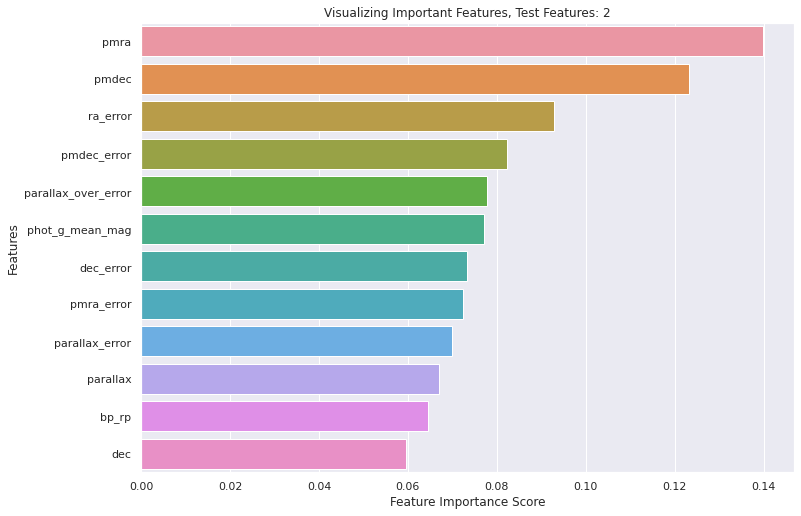

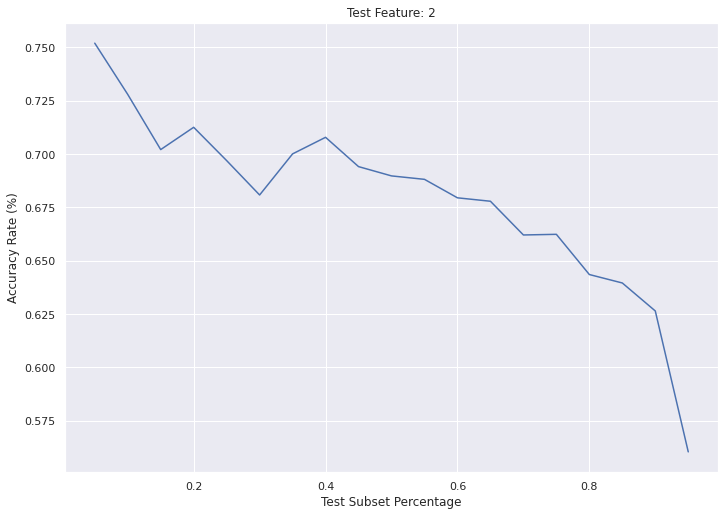

Test Features 3 : ['ra' 'ra_error' 'parallax' 'parallax_error' 'parallax_over_error' 'pmra'
 'pmra_error' 'pmdec' 'pmdec_error' 'dist_869_center' 'dist_884_center']


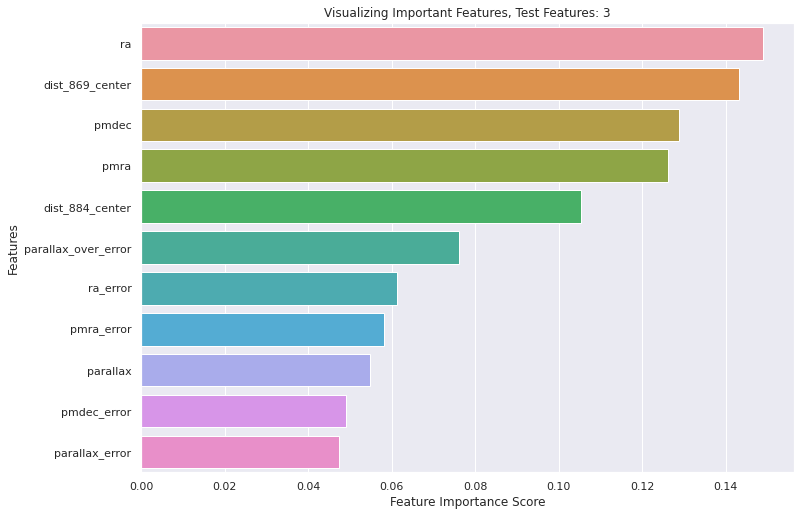

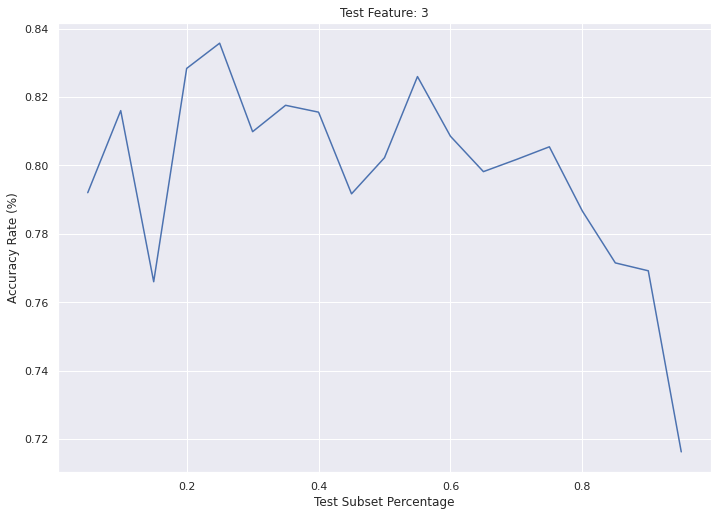

Test Features 4 : ['ra' 'ra_error' 'dec' 'dec_error' 'parallax' 'parallax_error'
 'parallax_over_error' 'pmra' 'pmra_error' 'pmdec' 'pmdec_error'
 'dist_869_center' 'dist_884_center']


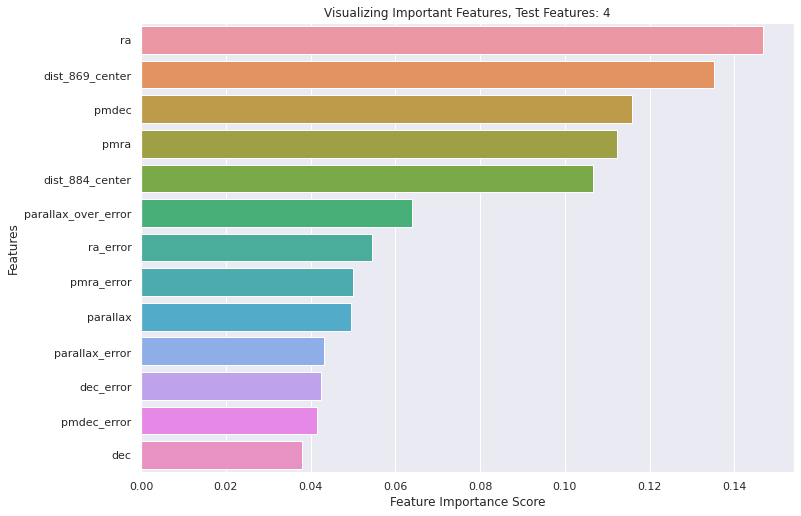

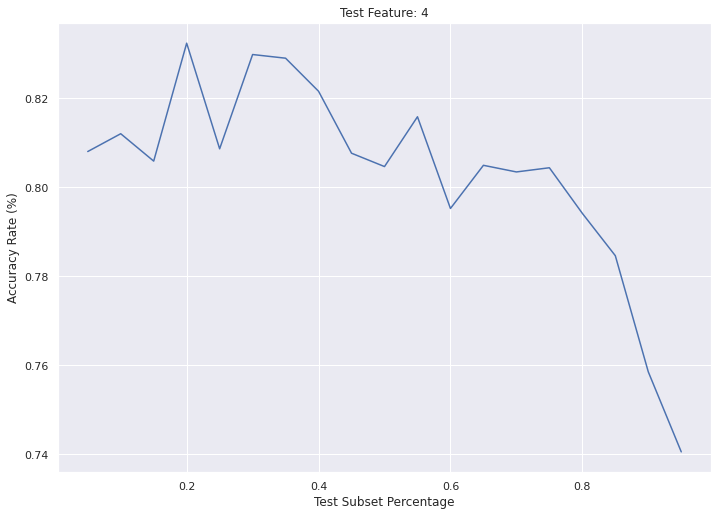

Test Features 5 : ['ra' 'ra_error' 'dec' 'dec_error' 'parallax' 'parallax_error'
 'parallax_over_error' 'pmra' 'pmra_error' 'pmdec' 'pmdec_error'
 'ra_dec_corr' 'ra_parallax_corr' 'ra_pmra_corr' 'ra_pmdec_corr'
 'dec_parallax_corr' 'dec_pmra_corr' 'dec_pmdec_corr' 'parallax_pmra_corr'
 'parallax_pmdec_corr' 'pmra_pmdec_corr' 'astrometric_n_obs_al'
 'astrometric_n_good_obs_al' 'astrometric_gof_al' 'astrometric_chi2_al'
 'astrometric_weight_al' 'astrometric_pseudo_colour'
 'astrometric_pseudo_colour_error' 'mean_varpi_factor_al'
 'astrometric_matched_observations' 'visibility_periods_used'
 'astrometric_sigma5d_max' 'matched_observations' 'phot_g_n_obs'
 'phot_g_mean_flux' 'phot_g_mean_flux_error' 'phot_g_mean_flux_over_error'
 'phot_g_mean_mag' 'phot_bp_n_obs' 'phot_bp_mean_flux'
 'phot_bp_mean_flux_error' 'phot_bp_mean_flux_over_error'
 'phot_bp_mean_mag' 'phot_rp_n_obs' 'phot_rp_mean_flux'
 'phot_rp_mean_flux_error' 'phot_rp_mean_flux_over_error'
 'phot_rp_mean_mag' 'phot_bp_rp_excess

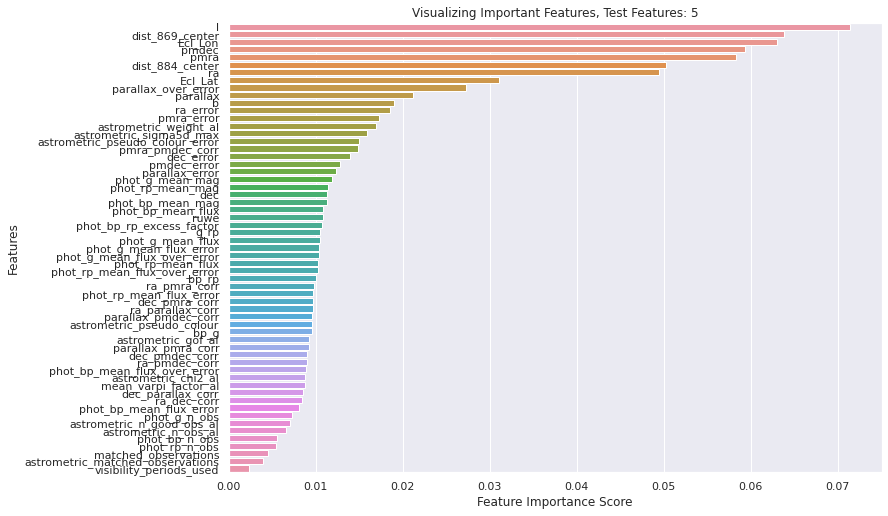

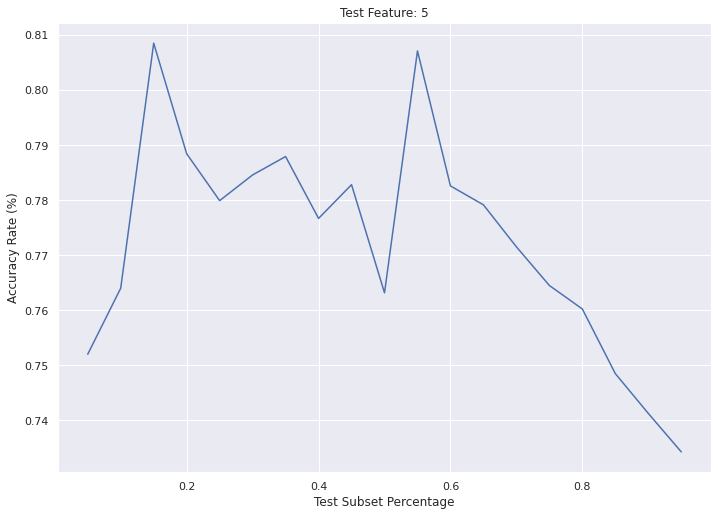

In [187]:
for i in range(5):
    features = testing[i]
    print('Test Features',i+1,':', features.columns.values)

    # Use Random Forest on whole dataset using 500 different trees 
    rfc = RandomForestClassifier(n_estimators = 500, oob_score = True)
    rfc.fit(features, targets)

    # checking the feature importance, 
    # ( this is higher for a variable if the model efficiency become lower as we remove that variable)
    feature_imp = pd.Series(rfc.feature_importances_, index=features.columns).sort_values(ascending = False)
    feature_imp


    # plotting as a barplot

    # Creating a bar plot
    sns.barplot(x=feature_imp, y=feature_imp.index)
    # Add labels to the graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features, Test Features: " +str(i+1))
    plt.show()



    # for each test_ratio, estimate the accuracy of the model

    accuracy_rate = []

    for ratio in test_ratio:
        test_features, test_targets, train_features, train_targets = test_train_split(features, targets, ratio)

        # train the model using only training subset
        rfc.fit(train_features, train_targets)

        # find the accuracy rate to predict the outcome for test subset
        test_predict = rfc.predict(test_features)
        accuracy = rfc.score(test_features, test_targets)

        accuracy_rate.append(accuracy)

    #print(accuracy_rate)



    # plotting the accuracy rate vs test-ratio

    sns.lineplot(test_ratio, accuracy_rate)
    plt.xlabel('Test Subset Percentage')
    plt.ylabel('Accuracy Rate (%)')
    plt.title('Test Feature: '+str(i+1))
    plt.show()

In [162]:
 # Use Random Forest on whole dataset using 500 different trees 
rfc = RandomForestClassifier(n_estimators = 500, oob_score = True)
rfc.fit(features, targets)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [163]:
# checking the feature importance, 
# ( this is higher for a variable if the model efficiency become lower as we remove that variable)
feature_imp = pd.Series(rfc.feature_importances_, index=features.columns).sort_values(ascending = False)
feature_imp

ra                     0.148386
dist_869_center        0.145226
pmdec                  0.129952
pmra                   0.124233
dist_884_center        0.105605
parallax_over_error    0.076018
ra_error               0.062884
pmra_error             0.056683
parallax               0.055952
parallax_error         0.047657
pmdec_error            0.047404
dtype: float64

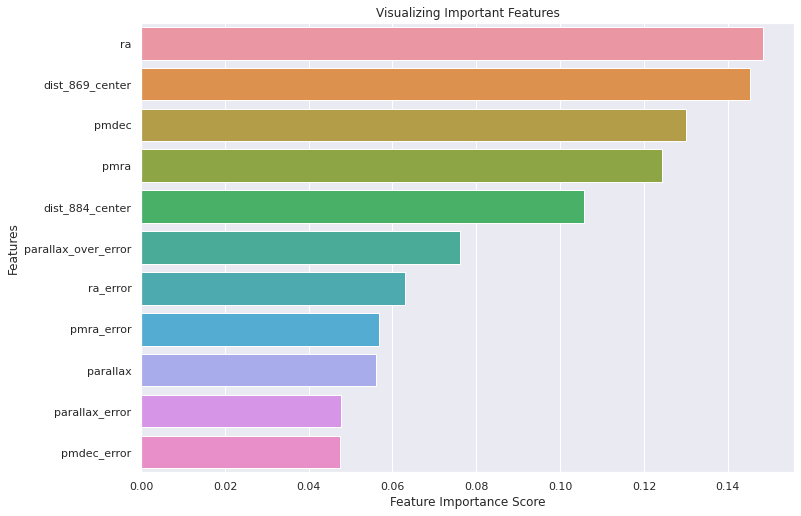

In [164]:
# plotting as a barplot

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [165]:
# for each test_ratio, estimate the accuracy of the model

accuracy_rate = []

for ratio in test_ratio:
  test_features, test_targets, train_features, train_targets = test_train_split(features, targets, ratio)

  # train the model using only training subset
  rfc.fit(train_features, train_targets)

  # find the accuracy rate to predict the outcome for test subset
  test_predict = rfc.predict(test_features)
  accuracy = rfc.score(test_features, test_targets)

  accuracy_rate.append(accuracy)

print(accuracy_rate)

[0.7678421494542401, 0.7780239255649092, 0.7860159549507274, 0.8005982053838484, 0.7910685805422647, 0.8056980056980056, 0.8165644171779141, 0.8018617021276596, 0.8063814358230602, 0.8149920255183413, 0.8093971631205674, 0.806580259222333, 0.8266818700114025, 0.8284574468085106, 0.8389154704944178, 0.8183632734530938, 0.824468085106383, 0.832, 0.816]


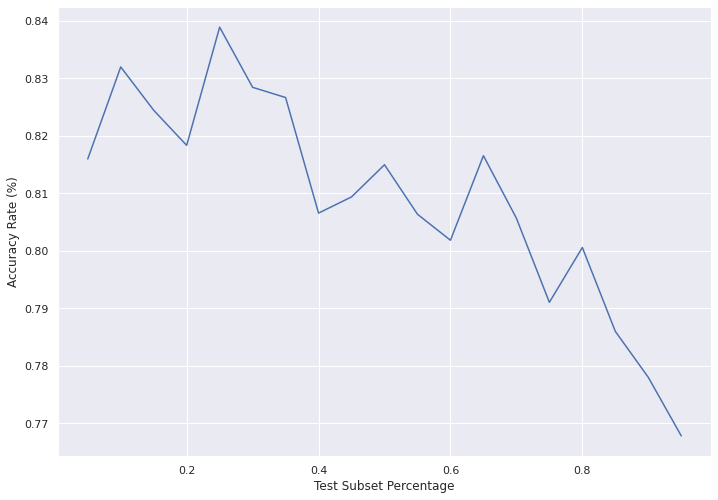

In [166]:
# plotting the accuracy rate vs test-ratio

sns.lineplot(test_ratio, accuracy_rate)
plt.xlabel('Test Subset Percentage')
plt.ylabel('Accuracy Rate (%)')
plt.show()

### Prediction of PMemb for the new stars

In [0]:
# Import all the stars from GAIA data around 30 m radius of cluster center
all_stars = pd.read_csv('binary_cluster_gaia60m.zip')
all_stars

Unnamed: 0           source_id  ...    Ecl_Lat      ruwe
0                0  458456770672134656  ...  40.236774  1.055825
1                1  458456805031733632  ...  40.237430  1.007278
2                2  458453845788270848  ...  40.234562  1.050665
3                3  458453850088715904  ...  40.233906  1.049487
4                4  458453811431452672  ...  40.232770  0.996634
...            ...                 ...  ...        ...       ...
197379      197379  457518195754219136  ...  39.255917  1.097421
197380      197380  457023930916454528  ...  40.185596  1.086483
197381      197381  458251230715782144  ...  39.315310  0.998954
197382      197382  457500917103328512  ...  39.249670       NaN
197383      197383  458830329735691264  ...  40.692333       NaN

[197384 rows x 59 columns]

In [0]:
### adding their distance from the center of both clusters

## NGC 869
center = coord.SkyCoord.from_name('NGC869')
center_ra, center_dec = center.ra.degree, center.dec.degree
distance = np.sqrt( (all_stars['ra'] - center_ra)**2 + (all_stars['dec'] - center_dec)**2 )
all_stars['dist_869_center'] = distance

## NGC 884
center = coord.SkyCoord.from_name('NGC884')
center_ra, center_dec = center.ra.degree, center.dec.degree
distance = np.sqrt( (all_stars['ra'] - center_ra)**2 + (all_stars['dec'] - center_dec)**2 )
all_stars['dist_884_center'] = distance


In [0]:
# checking the data types
all_stars.dtypes

Unnamed: 0                            int64
source_id                             int64
ra                                  float64
ra_error                            float64
dec                                 float64
dec_error                           float64
parallax                            float64
parallax_error                      float64
parallax_over_error                 float64
pmra                                float64
pmra_error                          float64
pmdec                               float64
pmdec_error                         float64
ra_dec_corr                         float64
ra_parallax_corr                    float64
ra_pmra_corr                        float64
ra_pmdec_corr                       float64
dec_parallax_corr                   float64
dec_pmra_corr                       float64
dec_pmdec_corr                      float64
parallax_pmra_corr                  float64
parallax_pmdec_corr                 float64
pmra_pmdec_corr                 

In [0]:
# descriptive stats
all_stars.describe()

Unnamed: 0     source_id  ...  dist_869_center  dist_884_center
count  197384.000000  1.973840e+05  ...    197384.000000    197384.000000
mean    98691.500000  4.582998e+17  ...         1.026215         0.990077
std     56979.997104  4.250813e+14  ...         0.511491         0.460875
min         0.000000  4.567620e+17  ...         0.001752         0.001112
25%     49345.750000  4.582901e+17  ...         0.658768         0.662087
50%     98691.500000  4.584141e+17  ...         0.946322         0.947978
75%    148037.250000  4.585445e+17  ...         1.341440         1.285860
max    197383.000000  4.588968e+17  ...         2.341818         2.188160

[8 rows x 61 columns]

In [0]:
# dropping the column with large null values 
all_stars = all_stars.drop(columns=['Unnamed: 0', 'astrometric_pseudo_colour',	'astrometric_pseudo_colour_error'])

# dropping the null values
all_stars = all_stars.dropna()

# change to 32-bit-float
all_stars = all_stars.astype('float32')

In [0]:
# checking the name of all columns in this dataset and the previous dataset to compare
member.columns

Index(['PMemb', 'Cluster', 'source_id', 'ra', 'ra_error', 'dec', 'dec_error',
       'parallax', 'parallax_error', 'parallax_over_error', 'pmra',
       'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr',
       'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr',
       'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr',
       'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_good_obs_al',
       'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_weight_al',
       'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error',
       'mean_varpi_factor_al', 'astrometric_matched_observations',
       'visibility_periods_used', 'astrometric_sigma5d_max',
       'matched_observations', 'phot_g_n_obs', 'phot_g_mean_flux',
       'phot_g_mean_flux_error', 'phot_g_mean_flux_over_error',
       'phot_g_mean_mag', 'phot_bp_n_obs', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_bp_mean_flux_over_error',
       'ph

In [0]:
all_stars.columns

Index(['Unnamed: 0', 'source_id', 'ra', 'ra_error', 'dec', 'dec_error',
       'parallax', 'parallax_error', 'parallax_over_error', 'pmra',
       'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr',
       'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr',
       'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr',
       'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_good_obs_al',
       'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_weight_al',
       'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error',
       'mean_varpi_factor_al', 'astrometric_matched_observations',
       'visibility_periods_used', 'astrometric_sigma5d_max',
       'matched_observations', 'phot_g_n_obs', 'phot_g_mean_flux',
       'phot_g_mean_flux_error', 'phot_g_mean_flux_over_error',
       'phot_g_mean_mag', 'phot_bp_n_obs', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_bp_mean_flux_over_error',
       'phot_bp_

In [0]:
# select the set of predictor variables from the new dataset
new_features = all_stars.loc[:,['ra',	'ra_error',	'dec', 'dec_error',	
                         'parallax', 'parallax_error',	'parallax_over_error', 
                         'pmra',	'pmra_error',	'pmdec',	'pmdec_error',
                         'phot_g_mean_mag', 'bp_rp', 'dist_869_center', 'dist_884_center']]

new_features = new_features.dropna()


In [0]:
# train the model again using all the features and targets of the previous dataset
rfc.fit(features, targets)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
# extimate the classification (NGC 869, NGC 884 or Field) of the stars
all_stars['Cluster'] = rfc.predict(new_features)

In [0]:
# estimate the membership probability of each class for each star
# output is a nx3 data table, where each column represent the probability of being in 
# 'field', 'NGC869' and 'NGC 884' class respectively.
class_predict = rfc.predict_proba(new_features)
class_predict

array([[0.739, 0.191, 0.07 ],
       [0.626, 0.025, 0.349],
       [0.22 , 0.013, 0.767],
       ...,
       [0.829, 0.121, 0.05 ],
       [0.9  , 0.073, 0.027],
       [0.762, 0.045, 0.193]])

In [0]:
rfc.classes_

array(['Field', 'NGC_869', 'NGC_884'], dtype=object)

In [0]:
## initialize the empty column
all_stars['PMemb'] = [-1]*len(all_stars)

# Adding the membership probability to the corresponding class
# (i.e. if a star is classified as 'NGC884' star, its PMemb represent the 
# probaility of being in 'NGC884')
field_star = all_stars['Cluster'] == 'Field'
ngc_869 = all_stars['Cluster'] == 'NGC_869'
ngc_884 = all_stars['Cluster'] == 'NGC_884'
all_stars.loc[field_star, 'PMemb'] =  class_predict[field_star, 0]
all_stars.loc[ngc_869, 'PMemb'] =  class_predict[ngc_869, 1]
all_stars.loc[ngc_884, 'PMemb'] =  class_predict[ngc_884, 2]


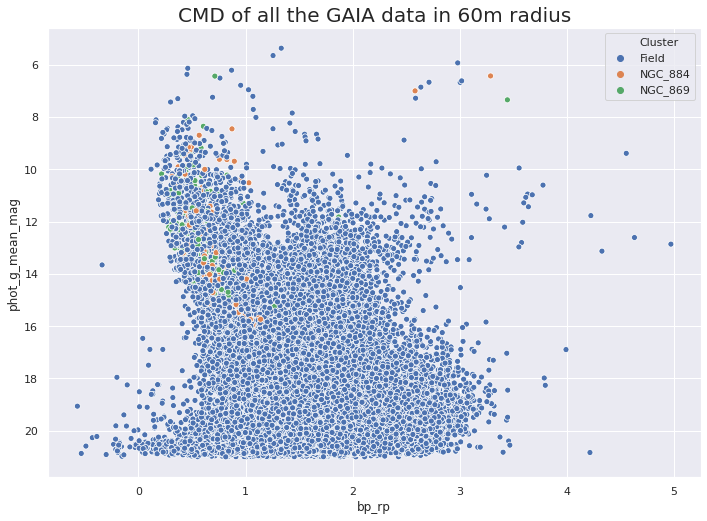

In [0]:
# CMD using all the stars where the membership Probability are expressed as the size of the dots

sns.set(rc={'figure.figsize':(11.7,8.27)})
cmd = sns.scatterplot(all_stars['bp_rp'], all_stars['phot_g_mean_mag'], hue = all_stars['Cluster'])
cmd.invert_yaxis()
plt.title('CMD of all the GAIA data in 60m radius', fontsize=20)
plt.show()

In [0]:
# define the subset of the probable members
potentialMember = all_stars[all_stars['Cluster'] != 'Field']
len(potentialMember)

2640

In [0]:
# comparing the descriptive stats of the all stars vs the probable members
all_stars.describe()

source_id             ra  ...  dist_884_center          PMemb
count  1.633260e+05  163326.000000  ...    163326.000000  163326.000000
mean   4.588903e+17      35.249310  ...         0.990467       0.843940
std    7.335022e+14       0.912213  ...         0.460520       0.093629
min    4.567620e+17      33.407810  ...         0.001112       0.343000
25%    4.582872e+17      34.517330  ...         0.662759       0.787000
50%    4.584117e+17      35.254129  ...         0.947489       0.869000
75%    4.585430e+17      35.978665  ...         1.286320       0.918000
max    4.588968e+17      37.091755  ...         2.188160       0.999000

[8 rows x 59 columns]

In [0]:
potentialMember.describe()

source_id           ra  ...  dist_884_center        PMemb
count  2.640000e+03  2640.000000  ...      2640.000000  2640.000000
mean   4.584140e+17    35.140930  ...         0.701577     0.778973
std    1.573434e+14     0.649279  ...         0.431442     0.188667
min    4.570401e+17    33.435268  ...         0.006608     0.343000
25%    4.583720e+17    34.679079  ...         0.321717     0.605000
50%    4.584071e+17    35.038141  ...         0.722664     0.840000
75%    4.584618e+17    35.560641  ...         0.990574     0.952000
max    4.588937e+17    37.078220  ...         2.166896     0.999000

[8 rows x 59 columns]

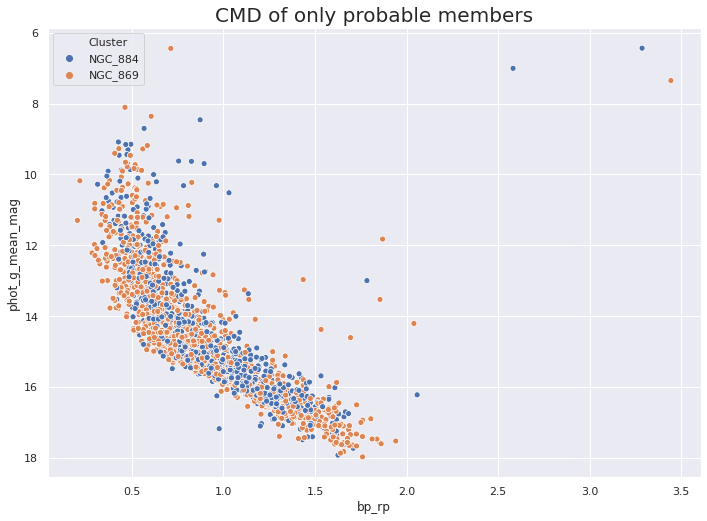

In [0]:
# CMD of only probable members 

sns.set(rc={'figure.figsize':(11.7,8.27)})
cmd2 = sns.scatterplot(potentialMember['bp_rp'], potentialMember['phot_g_mean_mag'], hue = potentialMember['Cluster'])
# plt.ylim(5,18)
cmd2.invert_yaxis()
plt.title('CMD of only probable members', fontsize=20)
plt.show()


### Comparing the new and old probable members

In [0]:
# creating subset for the potential member in previous dataset

potential_Old_Member = member[member['Cluster'] != 'Field']


concatenated = pd.concat([potentialMember.assign(dataset='New_member'), potential_Old_Member.assign(dataset='Old_member')])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [0]:
concatenated

Cluster    Ecl_Lat  ...     source_id  visibility_periods_used
2     NGC_884  40.234562  ...  4.584538e+17                     13.0
10    NGC_884  40.231632  ...  4.584538e+17                     13.0
24    NGC_869  40.244968  ...  4.584568e+17                     13.0
29    NGC_869  40.246456  ...  4.584568e+17                     13.0
63    NGC_869  40.252739  ...  4.584568e+17                     13.0
...       ...        ...  ...           ...                      ...
2519  NGC_884  40.304419  ...  4.584560e+17                     13.0
2520  NGC_884  40.309073  ...  4.584620e+17                     13.0
2521  NGC_884  40.197482  ...  4.584080e+17                     13.0
2525  NGC_884  40.107164  ...  4.584100e+17                     13.0
2528  NGC_884  40.153419  ...  4.584080e+17                     12.0

[4181 rows x 64 columns]

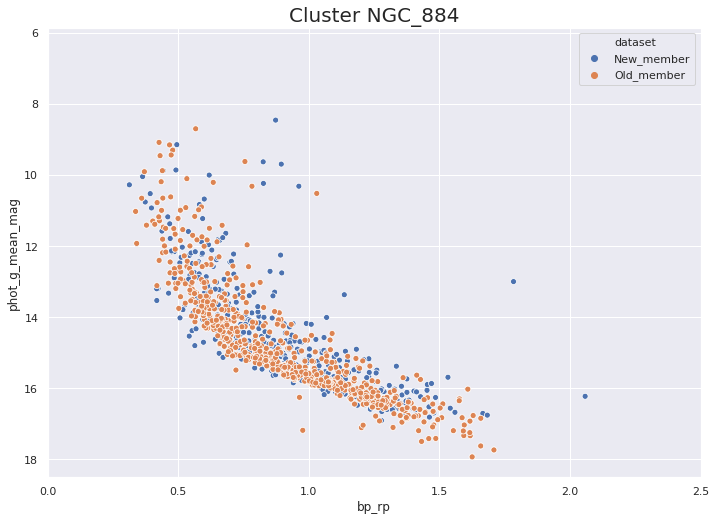

New Member:  1129
Old Member:  621


In [0]:
sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated[concatenated['Cluster'] == 'NGC_884'],
                hue='dataset').invert_yaxis()
plt.xlim(0,2.5)
plt.title('Cluster NGC_884', fontsize = 20)
plt.show()

print('New Member: ', len(potentialMember[potentialMember['Cluster'] == 'NGC_884']))
print('Old Member: ', len(potential_Old_Member[potential_Old_Member['Cluster'] == 'NGC_884']))

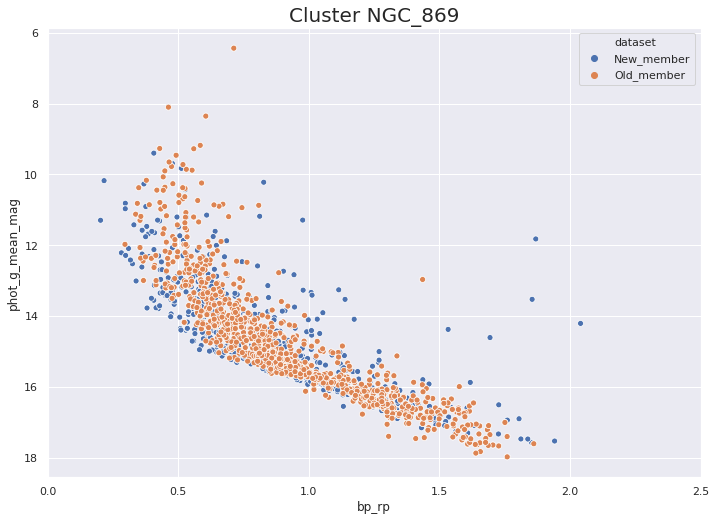

New Member:  1511
Old Member:  920


In [0]:
cmd = sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated[concatenated['Cluster'] == 'NGC_869'],
                hue='dataset')
cmd.invert_yaxis()
plt.xlim(0,2.5)
plt.title('Cluster NGC_869', fontsize = 20)
plt.show()

print('New Member: ', len(potentialMember[potentialMember['Cluster'] == 'NGC_869']))
print('Old Member: ', len(potential_Old_Member[potential_Old_Member['Cluster'] == 'NGC_869']))

Text(0.5, 1.0, 'Proper motion of the probable Members')

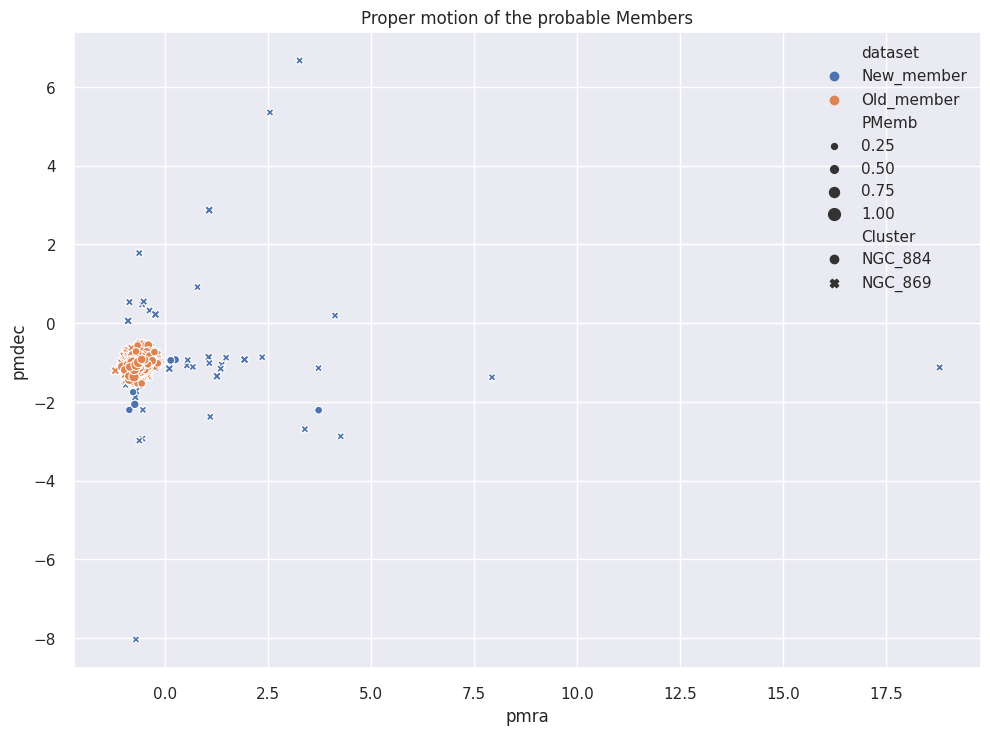

In [0]:
sns.scatterplot(x='pmra', y='pmdec', data=concatenated,
                style='Cluster', hue='dataset', size = 'PMemb')

#plt.xlim(-5,20)
#plt.ylim(-10,10)
plt.title('Proper motion of the probable Members')

In [0]:
concatenated.loc[concatenated['PMemb'] >= 0.6, 'Cluster'].value_counts()

NGC_869    1880
NGC_884    1318
Name: Cluster, dtype: int64

Text(0.5, 1.0, 'Skyplot of the probable Members')

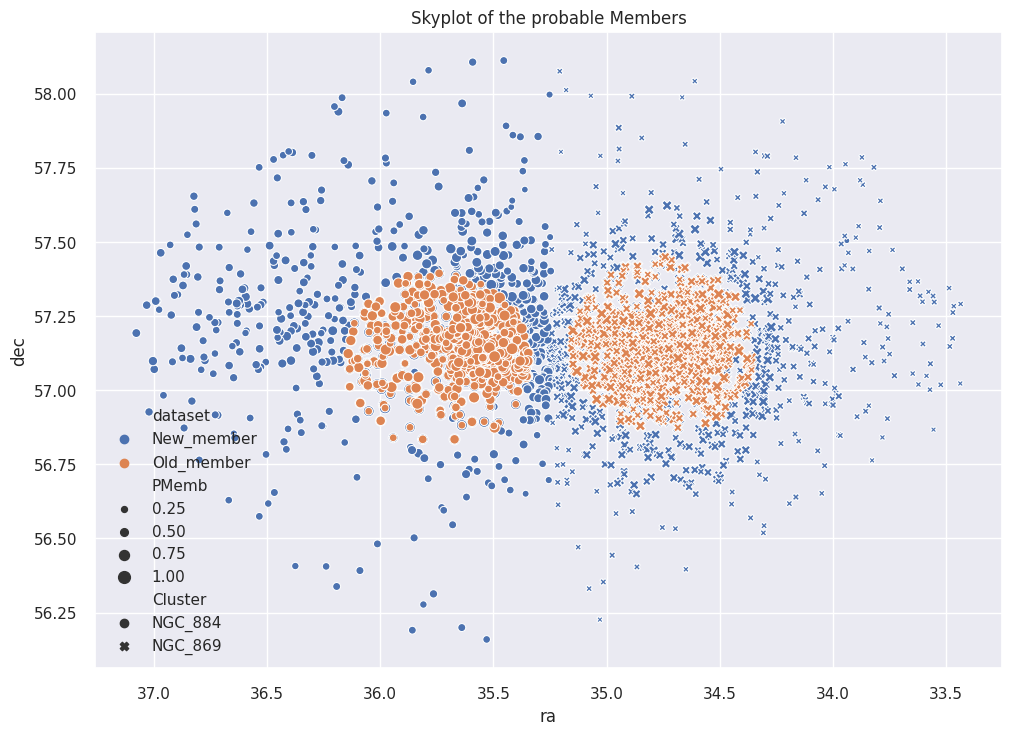

In [0]:
skyplot = sns.scatterplot(x='ra', y='dec', data=concatenated,
                style='Cluster', hue='dataset', size = 'PMemb')
skyplot.invert_xaxis()
plt.title('Skyplot of the probable Members')

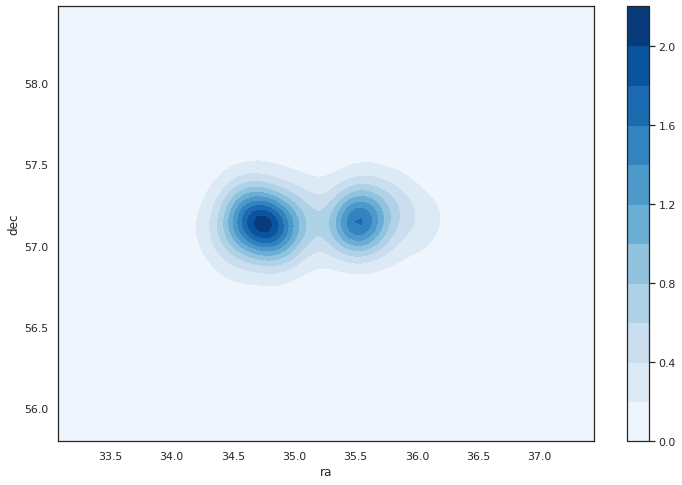

In [0]:
sns.set(rc={'figure.figsize':(12,8)})

x, y = concatenated['ra'], concatenated['dec']
sns.set_style("white")

sns.kdeplot(x, y, cmap="Blues", shade=True, shade_lowest=True, 
            cbar = True, bw = 0.12)
plt.show()

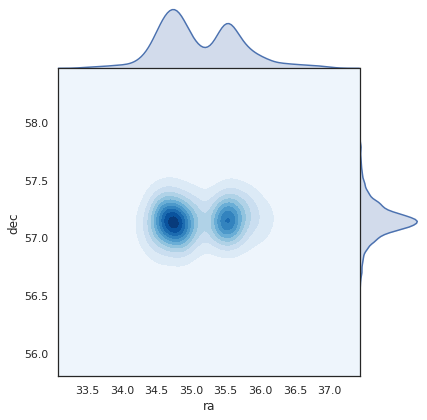

In [0]:
sns.jointplot(x, y, kind="kde", space=0, color="b", bw = 0.12, cmap = 'Blues')

plt.show()

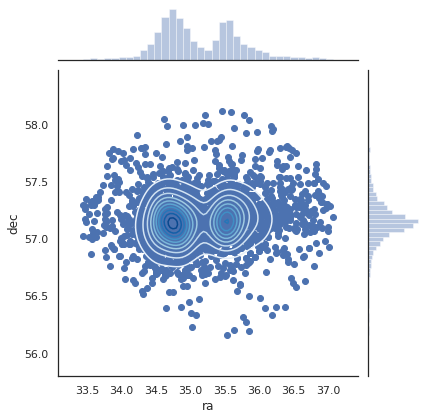

In [0]:
sns.jointplot(x, y, color="b").plot_joint(sns.kdeplot, n_levels = 10, cmap = 'Blues', bw = 0.12)

In [0]:
potentialMember.to_csv('binary_cluster_membership_prob.csv')
all_stars.to_csv('binary_cluster_gaia60m_classified.csv')

In [0]:
pd_prof.ProfileReport(potentialMember)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


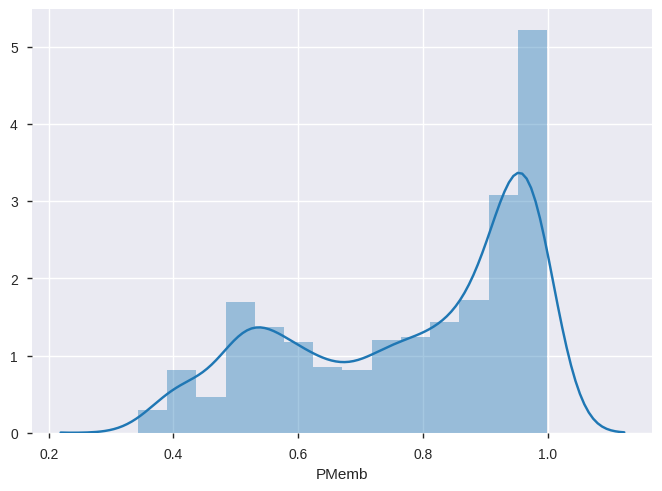

In [0]:
sns.distplot(potentialMember['PMemb'])